Razlicni grafi za seminarsko 2022
Za pretvorbo med alkoholom v izdihanem zraku in v krvi se uporablja 2,083.
https://www.utoledo.edu/studentaffairs/counseling/selfhelp/substanceuse/bac.html, ponuja vrednost 1 : 2100, vendar je legalna meja 0,5 g/kg krvi oziroma 0,24 mg/l, v izdihanem zraku. Koeficient je torej 2.083.


In [165]:
#init code
import math
import numpy as np
import matplotlib.pyplot as plt
from csv import DictReader
from PIL import Image
import random
import datetime as dt

data = []
for year in range(2009, 2021):
    data += list(DictReader(open(f'../data/pn{year}.csv', 'rt', encoding='utf-8'), delimiter=";"))

for row in data:
    row["VrednostAlkotesta"] = row["VrednostAlkotesta"].replace(",", ".")
    row["VrednostStrokovnegaPregleda"] = row["VrednostStrokovnegaPregleda"].replace(",", ".")


def create_geo_array():
    latitudes = []
    longitudes = []
    for row in data:
        latitude = float(row["GeoKoordinataX"])
        longitude = float(row["GeoKoordinataY"])
        if (longitude == 0.0 or latitude == 0.0):
            continue
        latitudes.append(float(row["GeoKoordinataX"]))
        longitudes.append(float(row["GeoKoordinataY"]))
    return np.array([latitudes, longitudes])


df_geo = create_geo_array()

def qulify_accident(amounts_dict, key, row):
    item = amounts_dict[key]
    item = (item[0] + 1, item[1], item[2])
    if (row["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO"):
        item = (item[0], item[1] + 1, item[2])
    elif (row["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM"):
        item = (item[0], item[1], item[2] + 1)
    amounts_dict[key] = item
    return amounts_dict


def accidents_by_alcohol_amount(tmp_data):
    amounts_dict = dict()
    i = 0
    for row in tmp_data:
        a_alc = float(row["VrednostStrokovnegaPregleda"])
        if (a_alc == 0):
            a_alc = float(row["VrednostAlkotesta"]) * 2.083
        if a_alc == 0:
            a_alc_class = 0
        elif (a_alc <= 0.5):
             a_alc_class = 0.5
        elif (a_alc <= 1):
            a_alc_class = 1
        elif (a_alc <= 1.5):
            a_alc_class = 1.5
        elif (a_alc <= 2):
            a_alc_class = 2
        elif (a_alc <= 2.5):
            a_alc_class = 2.5
        else:
            a_alc_class = 3
        if amounts_dict.get(a_alc_class) is not None:
            amounts_dict = qulify_accident(amounts_dict, a_alc_class, row)
        else:
            amounts_dict[a_alc_class] = (0, 0, 0)
            amounts_dict = qulify_accident(amounts_dict, a_alc_class, row)
    #print(i)
    return amounts_dict

get_alcohol_to_type = accidents_by_alcohol_amount(data)

In [109]:
#Geolocational graph

BBox = (df_geo[1].min(), df_geo[1].max(), df_geo[0].min(), df_geo[0].max())
slo_map = plt.imread('../data/map.png')

fig, ax = plt.subplots(figsize=(9, 8))
_ = ax.scatter(df_geo[1], df_geo[0], zorder=1, alpha=0.2, c='b', s=1)

ax.set_title('Lokacije nesreč v Sloveniji')
ax.set_xlim(BBox[0], BBox[1])
ax.set_ylim(BBox[2], BBox[3])
_ = ax.imshow(slo_map, zorder=0, extent=BBox, aspect='equal')

Ali obstaja povezava med vsebnostjo alkohola in resnostjo nesreč ?

In [111]:
def correlation_alchocol_accident_type(alcohol_to_type):
    accidents_alc = (0,0,0)
    accidents_sober = None
    for alc_amount in alcohol_to_type.keys():
        if (alc_amount > 0):
            x = alcohol_to_type[alc_amount]
            accidents_alc = (accidents_alc[0] + x[0], accidents_alc[1] + x[1], accidents_alc[2] + x[2])
        else:
            accidents_sober = alcohol_to_type[alc_amount]

    print(f"Smrt, trezen: {round(accidents_sober[2] / accidents_sober[0] * 100, 2)}%")
    print(f"Smrt, alkoholiziran: {round(accidents_alc[2] / accidents_alc[0] * 100, 2)}%")

    print(f"Težje poškodbe ali smrt, trezen: {round((accidents_sober[1] + accidents_sober[2])/ accidents_sober[0] * 100, 2)}%")
    print(f"Težje poškodbe ali smrt, alkoholiziran: {round((accidents_alc[1] + accidents_alc[2]) / accidents_alc[0] * 100, 2)}%")
correlation_alchocol_accident_type(get_alcohol_to_type)

Smrt, trezen: 0.66%
Smrt, alkoholiziran: 2.3%
Težje poškodbe ali smrt, trezen: 4.66%
Težje poškodbe ali smrt, alkoholiziran: 11.15%


Text(0.5, 0, 'Promil alkohola v krvi')

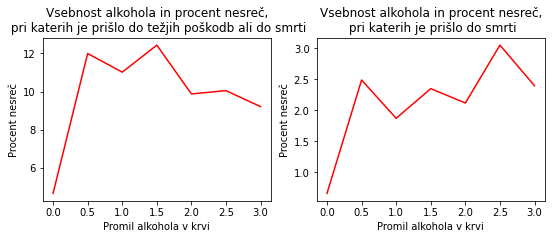

In [112]:
#Povezanost med vsebnostjo alkohola in nesrečami s težkimi poškodbami in smrtmi
alcohol_amounts = sorted(alcohol_to_type.keys())
ratios_injury_death = []
ratios_death = []
for key in alcohol_amounts:
    item = alcohol_to_type[key]
    try:
        ratios_injury_death.append((item[1] + item[2]) / item[0] * 100)
        ratios_death.append((item[2]) / item[0] * 100)
    except ZeroDivisionError:
        pass

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].plot(alcohol_amounts, ratios_injury_death ,c='r')

ax[1].plot(alcohol_amounts, ratios_death ,c='r')

ax[0].set_title('Vsebnost alkohola in procent nesreč,\n pri katerih je prišlo do težjih poškodb ali do smrti')
ax[1].set_title("Vsebnost alkohola in procent nesreč,\n pri katerih je prišlo do smrti")
ax[0].set_ylabel("Procent nesreč")
ax[0].set_xlabel("Promil alkohola v krvi")
ax[1].set_ylabel("Procent nesreč")
ax[1].set_xlabel("Promil alkohola v krvi")


In [113]:
count_above_proposed = 0
count_above_current = 0
count_above_max = 0
count_alcoholized = 0
for row in data:
    amount_of_alcohol = float(row["VrednostStrokovnegaPregleda"])
    if (amount_of_alcohol == 0):
        amount_of_alcohol = float(row["VrednostAlkotesta"]) * 2.083
    if (amount_of_alcohol > 0):
        count_alcoholized += 1
    if amount_of_alcohol > 0.2:
        count_above_proposed += 1
    if amount_of_alcohol > 0.5:
        count_above_current += 1
    if amount_of_alcohol > 1.1:
        count_above_max += 1
between_current_and_proposed = count_above_proposed-count_above_current
print(
    f"nad 0.2: {count_above_proposed}, \n"
    f"nad 0.5: {count_above_current}, \n"
    f"nad 1.1: {count_above_max} ({round(count_above_max / count_alcoholized * 100, 2)}%), \n"
    f"Število alkoholiziranih: {count_alcoholized}, \n"
    f"število nesreč: {len(data)}")
print(f"Med 0.2 in 0.5: {between_current_and_proposed} "
      f"({round(between_current_and_proposed / count_alcoholized * 100, 2)}%)")

nad 0.2: 24716, 
nad 0.5: 21501, 
nad 1.1: 15404 (54.51%), 
Število alkoholiziranih: 28257, 
število nesreč: 423446
Med 0.2 in 0.5: 3215 (11.38%)


In [111]:
#nivoAlkohola = []
#stanjeNesrece = []
#for row in data:
#    alc = float(row['VrednostStrokovnegaPregleda'])
#    if(alc == 0):
#        alc = float(row['VrednostAlkotesta']) * 2.083
#     
#    if(alc > 0):
#        nivoAlkohola.append(alc)
#        
#        klasifikacija = row['KlasifikacijaNesrece']
#        if(klasifikacija == 'Z MATERIALNO ŠKODO'):
#            stanjeNesrece.append(1)
#        elif(klasifikacija == 'Z LAŽJO POŠKODBO'):
#            stanjeNesrece.append(2)
#        elif(klasifikacija == 'S HUDO TELESNO POŠKODBO'):
#            stanjeNesrece.append(3)
#        elif(klasifikacija == 'S SMTRNIM IZIDOM'):
#            stanjeNesrece.append(4)
#        else:
#            stanjeNesrece.append(0)

In [112]:
#def pearson(x y):
#    return np.mean(((x - np.mean(x))*(y-np.mean(y)))/(np.std(x)*np.std(y)))

In [113]:
#pearson(nivoAlkohola stanjeNesrece)
#stanjeNesrece

In [114]:
tipNesrece = {}
for row in data:
    alc = float(row['VrednostStrokovnegaPregleda'])
    if(alc == 0):
        alc = float(row['VrednostAlkotesta']) * 2.083
            
    if(alc > 0):
        if(row['TipNesrece'] in tipNesrece):
            tipNesrece[row['TipNesrece']] = tipNesrece[row['TipNesrece']] + 1
        else:
            tipNesrece[row['TipNesrece']] = 1
    
vsotaNesrec = 0
for row in tipNesrece.items():
    vsotaNesrec = vsotaNesrec + row[1]
print(
    f"Število trčenj v objekt: {tipNesrece['TRČENJE V OBJEKT']}, \n"
    f"Število čelnih trčenj: {tipNesrece['ČELNO TRČENJE']}, \n"
    f"Število naletnih trčenj: {tipNesrece['NALETNO TRČENJE']}, \n"
    f"Število oplaženj: {tipNesrece['OPLAŽENJE']}, \n" 
    f"Število prevrnitev vozil: {tipNesrece['PREVRNITEV VOZILA']}, \n" 
    f"Število trčenj v stoječe / parkirano vozilo: {tipNesrece['TRČENJE V STOJEČE / PARKIRANO VOZILO']}, \n" 
    f"Število povoženj pešecev: {tipNesrece['POVOŽENJE PEŠCA']}, \n" 
    f"Število povoženj živali: {tipNesrece['POVOŽENJE ŽIVALI']}, \n" 
    f"Število ostalih vrst trčenj: {tipNesrece['OSTALO']}, \n" 
    f"Število nesreč v vinjenem stanju: {vsotaNesrec}")

Število trčenj v objekt: 4086, 
Število čelnih trčenj: 2836, 
Število naletnih trčenj: 2159, 
Število oplaženj: 2775, 
Število prevrnitev vozil: 3136, 
Število trčenj v stoječe / parkirano vozilo: 2257, 
Število povoženj pešecev: 743, 
Število povoženj živali: 117, 
Število ostalih vrst trčenj: 2334, 
Število nesreč v vinjenem stanju: 28257


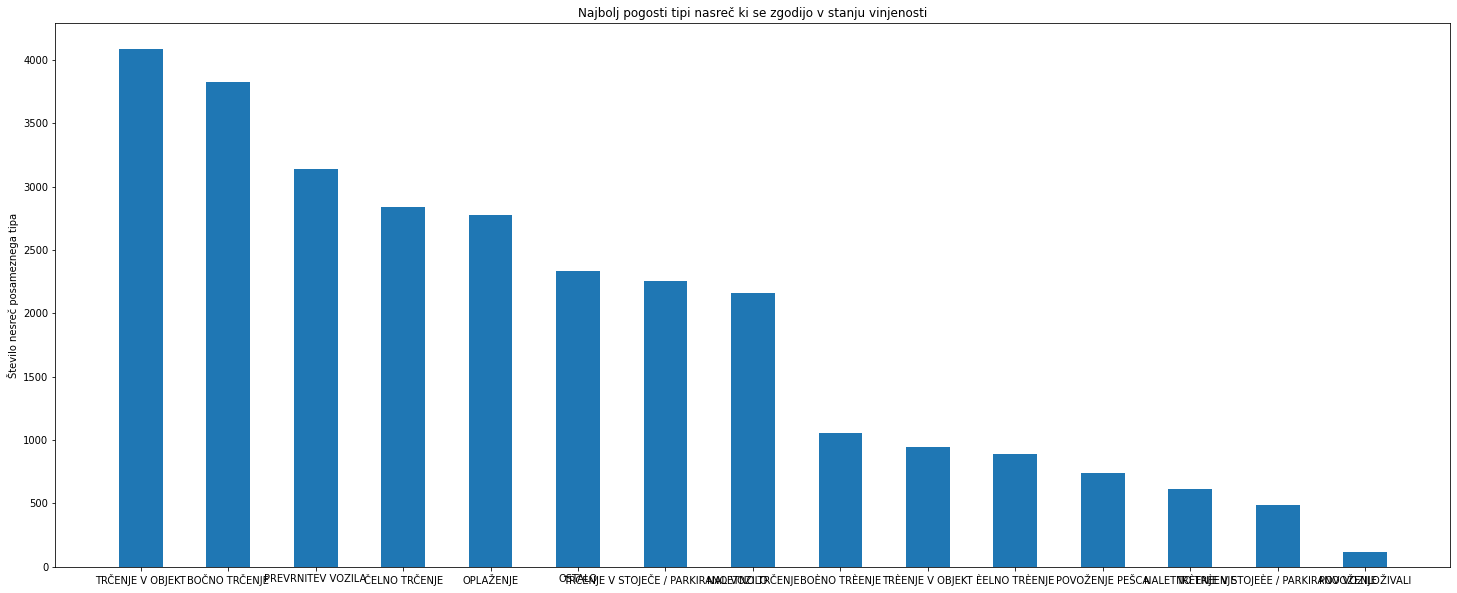

In [115]:
tipNesrece = dict(sorted(tipNesrece.items(), key=lambda item: item[1], reverse=True))
vrstaNesrec = [row for row in tipNesrece.keys()]
stNesrec = [tipNesrece[row] for row in vrstaNesrec]
    
fig = plt.figure(figsize = (25, 10))
plt.bar(vrstaNesrec, stNesrec, width=0.5)
     
plt.ylabel('Število nesreč posameznega tipa')
plt.title('Najbolj pogosti tipi nasreč ki se zgodijo v stanju vinjenosti')
plt.show()

In [116]:
starostneSkupine = {
    '10-14': 0,
    '15-19': 0,
    '20-24': 0,
    '25-29': 0,
    '30-34': 0,
    '35-39': 0,
    '40-44': 0,
    '45-49': 0,
    '50-54': 0,
    '55-59': 0,
    '60-64': 0,
    '65-69': 0,
    '70-74': 0,
    '75-79': 0,
    '80-84': 0,
    '85-89': 0,
    '90+': 0
}

for row in data:
    alc = float(row['VrednostStrokovnegaPregleda'])
    if(alc == 0):
        alc = float(row['VrednostAlkotesta']) * 2.083
            
    if(alc > 0):
        if(10 <= int(row['Starost']) < 15):
            starostneSkupine['10-14'] = starostneSkupine['10-14'] + 1
                
        elif(15 <= int(row['Starost']) < 20):
            starostneSkupine['15-19'] = starostneSkupine['15-19'] + 1
                
        elif(20 <= int(row['Starost']) < 25):
            starostneSkupine['20-24'] = starostneSkupine['20-24'] + 1
               
        elif(25 <= int(row['Starost']) < 30):
            starostneSkupine['25-29'] = starostneSkupine['25-29'] + 1
    
        elif(30 <= int(row['Starost']) <  35):
            starostneSkupine['30-34'] = starostneSkupine['30-34'] + 1
            
        elif(35 <= int(row['Starost']) <  40):
            starostneSkupine['35-39'] = starostneSkupine['35-39'] + 1
            
        elif(40 <= int(row['Starost']) <  45):
            starostneSkupine['40-44'] = starostneSkupine['40-44'] + 1
    
        elif(45 <= int(row['Starost']) < 50):
            starostneSkupine['45-49'] = starostneSkupine['45-49'] + 1
    
        elif(50 <= int(row['Starost']) < 55):
            starostneSkupine['50-54'] = starostneSkupine['50-54'] + 1
    
        elif(55 <= int(row['Starost']) < 60):
            starostneSkupine['55-59'] = starostneSkupine['55-59'] + 1
    
        elif(60 <= int(row['Starost']) <  65):
            starostneSkupine['60-64'] = starostneSkupine['60-64'] + 1
    
        elif(65 <= int(row['Starost']) < 70):
            starostneSkupine['65-69'] = starostneSkupine['65-69'] + 1
    
        elif(70 <= int(row['Starost']) < 75):
            starostneSkupine['70-74'] = starostneSkupine['70-74'] + 1
    
        elif(75 <= int(row['Starost']) < 80):
            starostneSkupine['75-79'] = starostneSkupine['75-79'] + 1
    
        elif(80 <= int(row['Starost']) <  85):
            starostneSkupine['80-84'] = starostneSkupine['80-84'] + 1
    
        elif(85 <= int(row['Starost']) < 90):
            starostneSkupine['85-89'] = starostneSkupine['85-89'] + 1
    
        else:
            starostneSkupine['90+'] = starostneSkupine['90+'] + 1

In [117]:
starostneSkupine

{'10-14': 7,
 '15-19': 1000,
 '20-24': 3415,
 '25-29': 3437,
 '30-34': 3164,
 '35-39': 2944,
 '40-44': 2768,
 '45-49': 2710,
 '50-54': 2474,
 '55-59': 2224,
 '60-64': 1626,
 '65-69': 1157,
 '70-74': 722,
 '75-79': 415,
 '80-84': 149,
 '85-89': 40,
 '90+': 5}

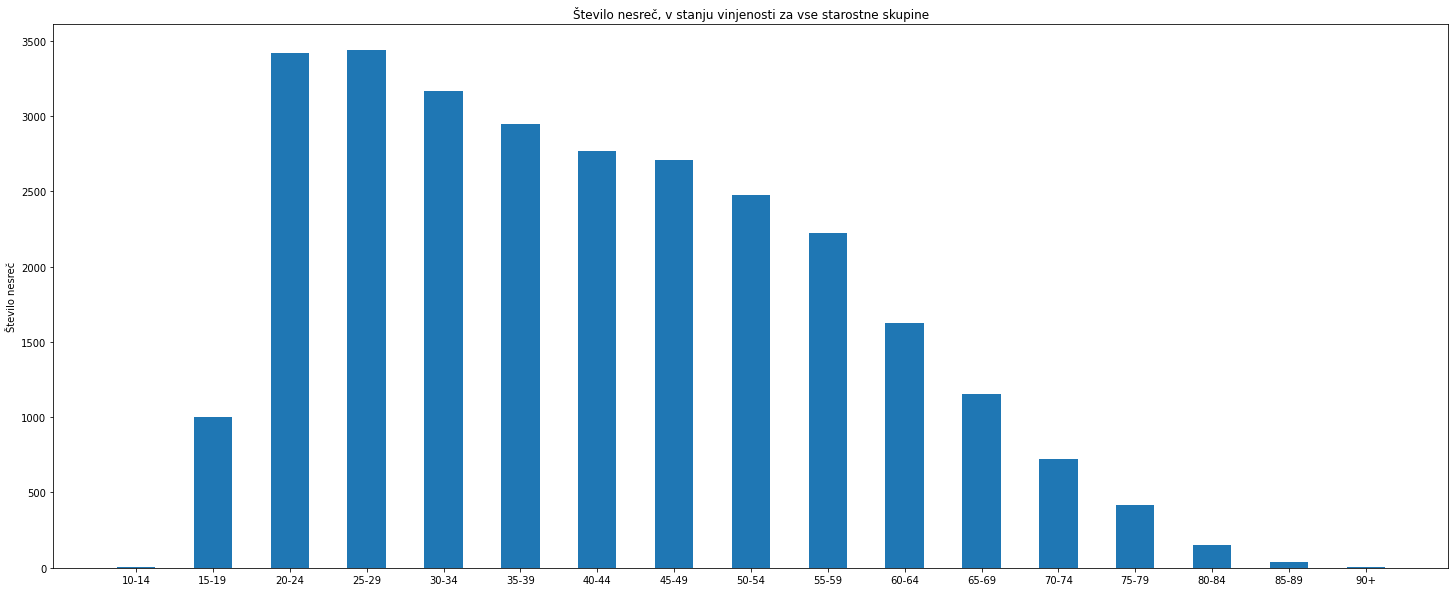

In [118]:
starostniRazmak = [row for row in starostneSkupine.keys()]
steviloPojavitev = [starostneSkupine[row] for row in starostniRazmak]

fig = plt.figure(figsize = (25, 10))
plt.bar(starostniRazmak, steviloPojavitev, width=0.5)

plt.ylabel("Število nesreč")
plt.title("Število nesreč, v stanju vinjenosti za vse starostne skupine")
plt.show()

Ali je alkohol glavni vzrok za hujše nesreče ?

In [119]:
#Razrede pretvorimo v številke

row = data[0]
x = row.keys()
for a in x:
    print(a)

# for row in data:
#     keys = row.keys()
#     for key in keys:
#         if (key == "UraPN"):
#             continue
#         elif (key == "SifraOdsekaUlice" or key == "GeoKoordinataX"or key == "GeoKoordinataY" or
#                 key == "ZaporednaStevilkaOsebeVPN" or key == "Starost" or key == "VozniskiStazVLetih" or
#                 key == "VozniskiStazVMesecih" or key == "VrednostAlkotesta" or key == "VrednostStrokovnegaPregleda")


ZaporednaStevilkaPN
KlasifikacijaNesrece
UpravnaEnotaStoritve
DatumPN
UraPN
VNaselju
Lokacija
VrstaCesteNaselja
SifraCesteNaselja
TekstCesteNaselja
SifraOdsekaUlice
TekstOdsekaUlice
StacionazaDogodka
OpisKraja
VzrokNesrece
TipNesrece
VremenskeOkoliscine
StanjePrometa
StanjeVozisca
VrstaVozisca
GeoKoordinataX
GeoKoordinataY
ZaporednaStevilkaOsebeVPN
Povzrocitelj
Starost
Spol
UEStalnegaPrebivalisca
Drzavljanstvo
PoskodbaUdelezenca
VrstaUdelezenca
UporabaVarnostnegaPasu
VozniskiStazVLetih
VozniskiStazVMesecih
VrednostAlkotesta
VrednostStrokovnegaPregleda


In [120]:
def normalise(x, min_value, max_value, scale):
    return math.floor(((x-min_value) / (max_value-min_value)) * scale)

def get_traffic_amount(color):
    if color in [(0, 0, 0), (255, 255, 255), (252, 252, 254), (252, 252, 250), (248, 248, 247)]:
        return "0"
    elif color in [(242, 98, 96), (222, 137, 152)]:
        return "nad 20000"
    elif color in [(163, 194, 226), (104, 155, 217), (22, 118, 237)]:
        return "nad 10000"
    elif color in [(208, 187, 198), (170, 132, 164)]:
        return "nad 5000"
    elif color in [(172, 217, 144), (141, 219, 82)]:
        return "nad 1000"
    elif color in [(230, 230, 219), (229, 225, 163), (255, 255, 1)]:
        return "do 1000"
    else:
        return "null"

#df_geo[0] is x
#df_geo[1] is y

BBox = (df_geo[0].min(), df_geo[0].max(), df_geo[1].min(), df_geo[1].max())
def rate_bounds(img, bounds: tuple):
    count_resolved = 0
    img_crop = img.crop(bounds)
    for row in data:
        latitude = float(row["GeoKoordinataX"])
        longitude = float(row["GeoKoordinataY"])
        #if (longitude == 0.0 or latitude == 0.0):
        #    continue
        pixel_x = normalise(latitude, BBox[0], BBox[1], img_crop.size[0])
        pixel_y = normalise(longitude, BBox[2], BBox[3], img_crop.size[1])
        try:
            traffic_amount = get_traffic_amount(img_crop.getpixel((pixel_x, pixel_y)))
            if traffic_amount != "null" and traffic_amount != "0":
                count_resolved += 1
        except Exception as e:
           pass
    return count_resolved

def create_bounds(original = False):
    map = Image.open("../data/razporeditev prometa.png")
    if original:
        left = 0
        top = 0
        right = map.size[0]
        bottom = map.size[1]
    else:
        left = random.randint(1, 10)
        top = random.randint(1, 10)
        right = map.size[0] - random.randint(1, 10)
        bottom = map.size[1] - random.randint(1, 10)
    bounds = (left, top, right, bottom)
    rating = rate_bounds(map, bounds)
    return bounds, rating
# The crop on the image is not right, we try random crops and see how well the accidents cover the roads
# bounds_dict = {}
# bounds, rating = create_bounds(original=True)
# print("With no crop: " + str(rating))
# for i in range(1000):
#     bounds, rating = create_bounds()
#     bounds_dict[rating] = bounds
# for key in sorted(bounds_dict):
#     print("%s: %s" % (key, bounds_dict[key]))

"""
With no crop: 228703
200368: (10, 10, 914, 610)
200677: (3, 10, 913, 610)
202363: (7, 10, 912, 610)
203681: (1, 10, 911, 610)
.
.
.
251797: (2, 3, 905, 607)
251993: (3, 2, 905, 608)
252651: (3, 3, 905, 607)
257237: (4, 3, 905, 606)
258134: (6, 2, 905, 606)
265361: (6, 1, 905, 607)
267207: (4, 1, 905, 608)
"""

'\nWith no crop: 228703\n200368: (10, 10, 914, 610)\n200677: (3, 10, 913, 610)\n202363: (7, 10, 912, 610)\n203681: (1, 10, 911, 610)\n.\n.\n.\n251797: (2, 3, 905, 607)\n251993: (3, 2, 905, 608)\n252651: (3, 3, 905, 607)\n257237: (4, 3, 905, 606)\n258134: (6, 2, 905, 606)\n265361: (6, 1, 905, 607)\n267207: (4, 1, 905, 608)\n'

In [121]:
# Finally adding the traffic amount column
map = Image.open("../data/razporeditev prometa.png")
img_crop = map.crop((4, 1, 905, 608))
for row in data:
    latitude = float(row["GeoKoordinataX"])
    longitude = float(row["GeoKoordinataY"])
    #if (longitude == 0.0 or latitude == 0.0):
    #    continue
    pixel_x = normalise(latitude, BBox[0], BBox[1], img_crop.size[0])
    pixel_y = normalise(longitude, BBox[2], BBox[3], img_crop.size[1])
    try:
        traffic_amount = get_traffic_amount(img_crop.getpixel((pixel_x, pixel_y)))
        row["Gostota prometa"] = traffic_amount
    except Exception as e:
       row["Gostota prometa"] = "0"

In [122]:
drunk_drivers = [[], []]
for row in data:
    alc = float(row['VrednostStrokovnegaPregleda'])
    if(alc == 0):
        alc = float(row['VrednostAlkotesta']) * 2.083
            
    if(alc > 0):
        if (row["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO"):
            drunk_drivers[0].append(row)
        elif (row["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM"):
            drunk_drivers[1].append(row)

# 0, do 1000, nad 1000, nad 5000, nad 10.000, nad 20.000
# S hudo telesno poškodbo
major_injury_data = {}
for row in drunk_drivers[0]:
    if(row['Gostota prometa'] in major_injury_data):
        major_injury_data[row['Gostota prometa']] += 1
    else:
        major_injury_data[row['Gostota prometa']] = 1

# S smrtnim izzidom
death_result_data = {}
for row in drunk_drivers[1]:
    if(row['Gostota prometa'] in death_result_data):
        death_result_data[row['Gostota prometa']] += 1
    else:
        death_result_data[row['Gostota prometa']] = 1

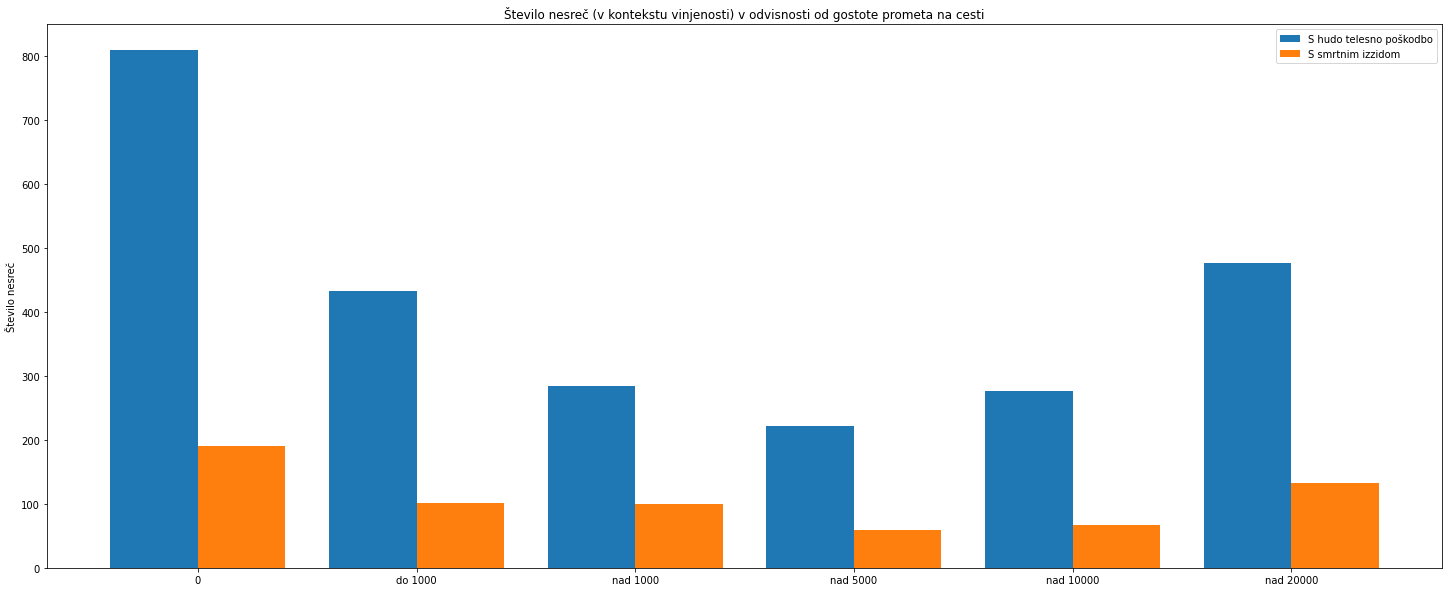

In [123]:
dataX = ['0', 'do 1000', 'nad 1000', 'nad 5000', 'nad 10000', 'nad 20000']
major_injury_graph = [major_injury_data[key] for key in dataX]
death_result_graph = [death_result_data[key] for key in dataX]
  
X_axis = np.arange(len(dataX))

fig = plt.figure(figsize = (25, 10))
plt.bar(X_axis - 0.2, major_injury_graph, 0.4, label = 'S hudo telesno poškodbo')
plt.bar(X_axis + 0.2, death_result_graph, 0.4, label = 'S smrtnim izzidom')

plt.xticks(X_axis, dataX)
plt.ylabel("Število nesreč")
plt.title("Število nesreč (v kontekstu vinjenosti) v odvisnosti od gostote prometa na cesti")
plt.legend()
plt.show()

In [134]:
# Primerjava pred 2011 povečanjem kazni za vinjene voznike z po 2011
before_data = []
after_data = []

date_of_new_laws = dt.strptime("01.10.2011", "%d.%m.%Y")
for row in data:
    check_date = dt.strptime(row['DatumPN'], "%d.%m.%Y")
    if(check_date < date_of_new_laws):
        before_data.append(row)
    else:
        after_data.append(row)

In [139]:
def count_drunk_drivers(tmp_data):
    count = 0
    for row in tmp_data:
        alc = float(row['VrednostStrokovnegaPregleda'])
        if(alc == 0):
            alc = float(row['VrednostAlkotesta']) * 2.083

        if(alc > 0):
            count += 1
    return count

In [144]:
print('Pred uvedbo novih zakonov')
print(f"Verjetnost, da bo vozil vinjen: {round(count_drunk_drivers(before_data) / len(before_data), 3)}%")
get_data = accidents_by_alcohol_amount(before_data)
correlation_alchocol_accident_type(get_data)

Pred uvedbo novih zakonov
Verjetnost, da bo vozil vinjen: 0.068%
Smrt, trezen: 0.73%
Smrt, alkoholiziran: 2.55%
Težje poškodbe ali smrt, trezen: 4.81%
Težje poškodbe ali smrt, alkoholiziran: 11.55%


In [145]:
print('Po uvedbi novih zakonov')
print(f"Verjetnost, da bo vozil vinjen: {round(count_drunk_drivers(after_data) / len(after_data), 3)}%")
get_data = accidents_by_alcohol_amount(after_data)
correlation_alchocol_accident_type(get_data)

Po uvedbi novih zakonov
Verjetnost, da bo vozil vinjen: 0.066%
Smrt, trezen: 0.63%
Smrt, alkoholiziran: 2.21%
Težje poškodbe ali smrt, trezen: 4.61%
Težje poškodbe ali smrt, alkoholiziran: 11.0%


In [146]:
# Kdaj se take nesreče najpogosteje zgodijo
time_data = []
for row in data:
    alc = float(row['VrednostStrokovnegaPregleda'])
    if(alc == 0):
        alc = float(row['VrednostAlkotesta']) * 2.083

    if(alc > 0):
        time_data.append(row['UraPN'])